In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import scipy.stats
from scipy.optimize import curve_fit
from scipy.misc import factorial

import pickle
from sklearn.feature_extraction.text import CountVectorizer

from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson, Logit

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [4]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [5]:
discipline = "Transportation"
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [6]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [7]:
vectorized_wordarray.shape

(62, 21687)

In [8]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 62/62 [00:00<00:00, 1806.93it/s]


In [9]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)
    
for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)    

100%|██████████| 61/61 [00:00<00:00, 381.99it/s]


__Years:__ 2010 - 2015

In [10]:
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

Optimization terminated successfully.
         Current function value: 2.341925
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.248179
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.291177
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.361935
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.011884
         Iterations 1


Text(0.5,1,'2014: -7.44')

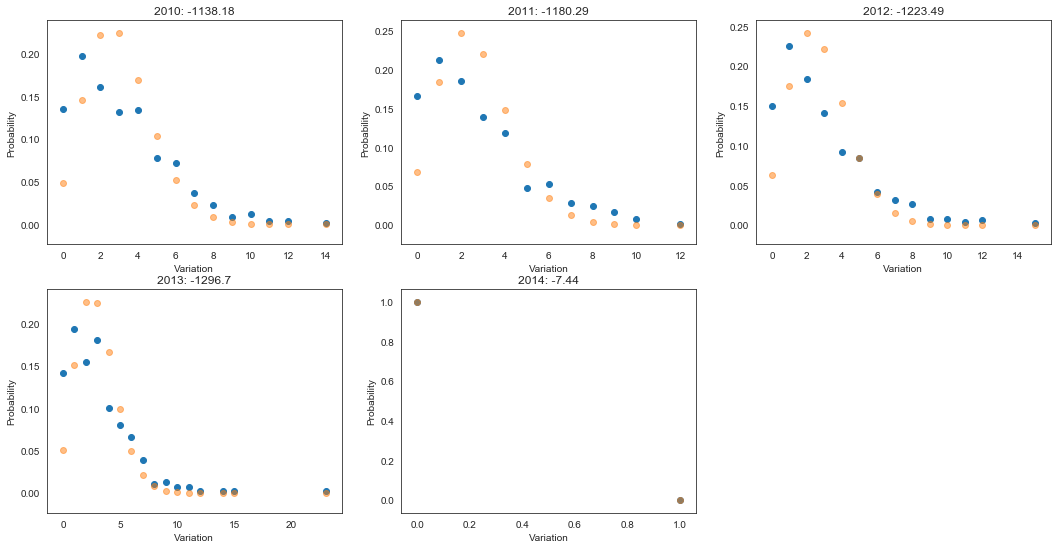

In [11]:
K = 3
f = plt.figure(figsize=(18,14))


year = 2010
N = 56
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax.scatter(X, Y_poiss, alpha=0.5)
ax.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))



year = 2011
N = 57
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax2.scatter(X, Y_poiss, alpha=0.5)
ax2.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2012
N = 58
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax3.scatter(X, Y_poiss, alpha=0.5)
ax3.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2013
N = 59
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)


poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax4.scatter(X, Y_poiss, alpha=0.5)
ax4.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2014
N = 60
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)


poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax5.scatter(X, Y_poiss, alpha=0.5)
ax5.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))

Optimization terminated successfully.
         Current function value: 3.085611
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.819961
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.966125
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.221324
         Iterations 1


Text(0.5,1,'2013: -454.21')

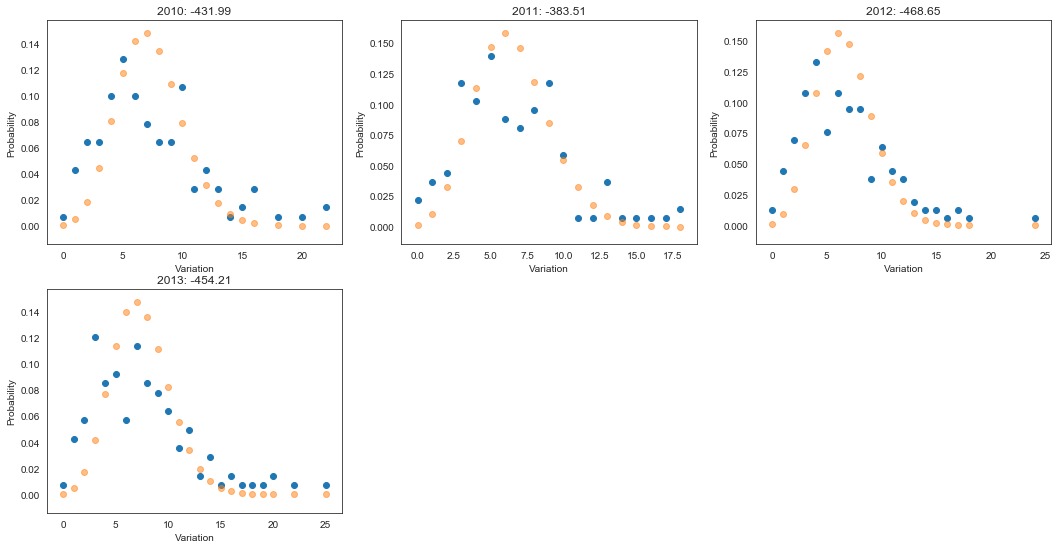

In [16]:
K = 7
f = plt.figure(figsize=(18,14))


year = 2010
N = 56
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax.scatter(X, Y_poiss, alpha=0.5)
ax.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))



year = 2011
N = 57
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax2.scatter(X, Y_poiss, alpha=0.5)
ax2.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2012
N = 58
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax3.scatter(X, Y_poiss, alpha=0.5)
ax3.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2013
N = 59
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)


poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax4.scatter(X, Y_poiss, alpha=0.5)
ax4.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




# year = 2014
# N = 60
# freq_current = list(vectorized_wordarray[N:N+1,:][0])
# freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
# indices = [i for i, x in enumerate(freq_current) if x == K]
# change_in_values = [freq_next[i] for i in indices]
# variations = [j - K for j in change_in_values]
# sum_ = sum(dict(Counter(variations)).values())
# X = [x + K for x,y in dict(Counter(variations)).items()]
# Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
# ax5 = f.add_subplot(335)
# ax5.scatter(X, Y)
# ax5.set_xlabel("Variation")
# ax5.set_ylabel("Probability")
# ax5.set_title(str(year) + " - Word Variations in " + discipline)


# poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
# poissonRes = poissonModel.fit()
# poissonModel.loglike(poissonRes.params)

# lambda_ = np.exp(poissonRes.params[0])
# Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
# ax5.scatter(X, Y_poiss, alpha=0.5)
# ax5.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))

Optimization terminated successfully.
         Current function value: 3.216454
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.042769
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.178222
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.857842
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.116082
         Iterations 1


Text(0.5,1,'2014: -9.4')

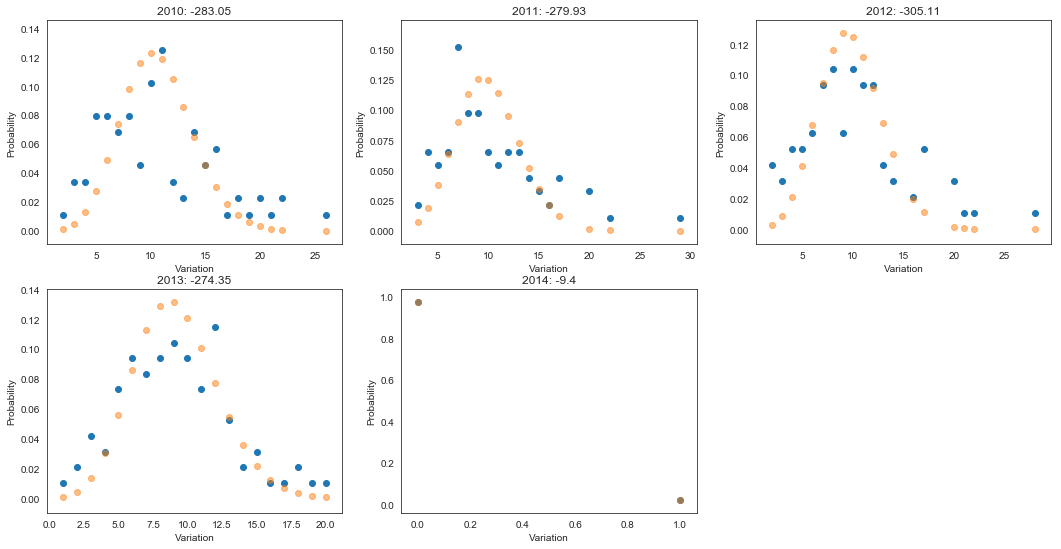

In [13]:
K = 10
f = plt.figure(figsize=(18,14))


year = 2010
N = 56
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax.scatter(X, Y_poiss, alpha=0.5)
ax.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))



year = 2011
N = 57
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax2.scatter(X, Y_poiss, alpha=0.5)
ax2.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2012
N = 58
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax3.scatter(X, Y_poiss, alpha=0.5)
ax3.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2013
N = 59
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)


poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax4.scatter(X, Y_poiss, alpha=0.5)
ax4.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




# year = 2014
# N = 60
# freq_current = list(vectorized_wordarray[N:N+1,:][0])
# freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
# indices = [i for i, x in enumerate(freq_current) if x == K]
# change_in_values = [freq_next[i] for i in indices]
# variations = [j - K for j in change_in_values]
# sum_ = sum(dict(Counter(variations)).values())
# X = [x + K for x,y in dict(Counter(variations)).items()]
# Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
# ax5 = f.add_subplot(335)
# ax5.scatter(X, Y)
# ax5.set_xlabel("Variation")
# ax5.set_ylabel("Probability")
# ax5.set_title(str(year) + " - Word Variations in " + discipline)


# poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
# poissonRes = poissonModel.fit()
# poissonModel.loglike(poissonRes.params)

# lambda_ = np.exp(poissonRes.params[0])
# Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
# ax5.scatter(X, Y_poiss, alpha=0.5)
# ax5.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))

Optimization terminated successfully.
         Current function value: 3.409084
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.105674
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.343944
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.041860
         Iterations 1


Text(0.5,1,'2013: -121.67')

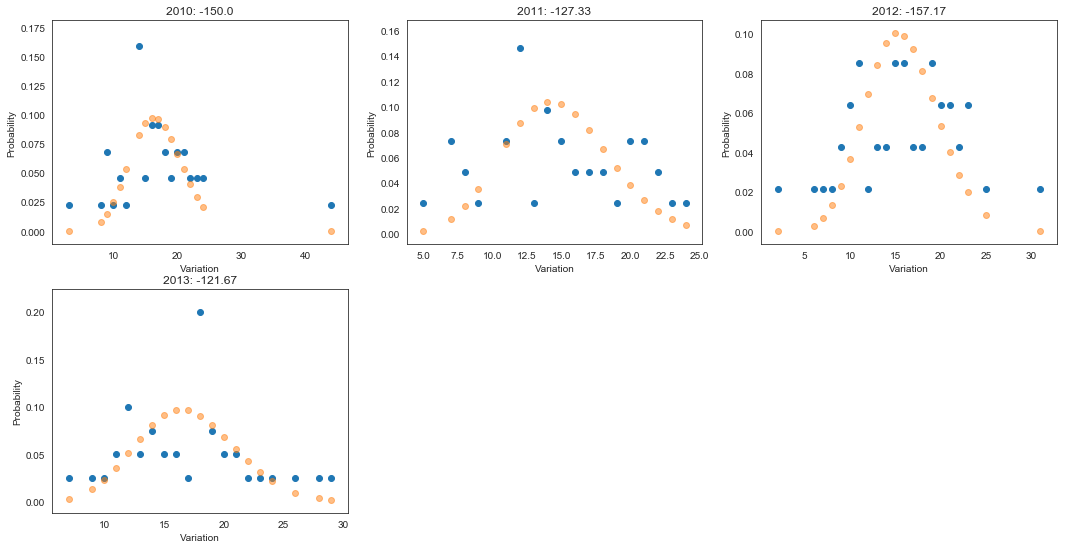

In [15]:
K = 15
f = plt.figure(figsize=(18,14))


year = 2010
N = 56
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax.scatter(X, Y_poiss, alpha=0.5)
ax.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))



year = 2011
N = 57
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax2.scatter(X, Y_poiss, alpha=0.5)
ax2.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2012
N = 58
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax3.scatter(X, Y_poiss, alpha=0.5)
ax3.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




year = 2013
N = 59
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x + K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)


poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
poissonModel.loglike(poissonRes.params)

lambda_ = np.exp(poissonRes.params[0])
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
ax4.scatter(X, Y_poiss, alpha=0.5)
ax4.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))




# year = 2014
# N = 60
# freq_current = list(vectorized_wordarray[N:N+1,:][0])
# freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
# indices = [i for i, x in enumerate(freq_current) if x == K]
# change_in_values = [freq_next[i] for i in indices]
# variations = [j - K for j in change_in_values]
# sum_ = sum(dict(Counter(variations)).values())
# X = [x + K for x,y in dict(Counter(variations)).items()]
# Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
# ax5 = f.add_subplot(335)
# ax5.scatter(X, Y)
# ax5.set_xlabel("Variation")
# ax5.set_ylabel("Probability")
# ax5.set_title(str(year) + " - Word Variations in " + discipline)


# poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
# poissonRes = poissonModel.fit()
# poissonModel.loglike(poissonRes.params)

# lambda_ = np.exp(poissonRes.params[0])
# Y_poiss = list(map(lambda x: poisson(x, lambda_), X))
# ax5.scatter(X, Y_poiss, alpha=0.5)
# ax5.set_title(str(year) + ": " + str(round(poissonModel.loglike(poissonRes.params),2)))